In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

Bagian ini mengimpor semua library yang diperlukan untuk pemrosesan data, visualisasi, pelatihan model, dan evaluasi.
torchvision digunakan untuk load dataset dan pretrained model.
seaborn dan matplotlib untuk visualisasi hasil.

# Setup Device dan Transformasi Gambar

In [38]:
# Gunakan GPU jika tersedia, kalau tidak pakai CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device yang digunakan:", device)

# Transformasi gambar yang harus dilakukan sebelum input ke model
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize gambar sesuai input VGG16
    transforms.ToTensor(),  # Konversi gambar ke tensor PyTorch
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi sesuai pretrained model
                         [0.229, 0.224, 0.225])
])


Device yang digunakan: cuda


device menentukan apakah pelatihan akan menggunakan GPU (jika ada) atau CPU.
transform merubah gambar menjadi ukuran 224x224 (VGG16 butuh ukuran ini) dan menormalisasi pixel berdasarkan mean dan std yang digunakan pada saat pretrained model dilatih.

# Load Dataset & Split Train-Test

In [39]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

data_dir = '/kaggle/input/face-mask-dataset/data'

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
print("Kelas yang ada:", class_names)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Kelas yang ada: ['with_mask', 'without_mask']


Menggunakan ImageFolder karena dataset sudah dalam folder yang terstruktur berdasarkan kelas.
Dataset di-split manual jadi 80% untuk training, 20% untuk testing.
DataLoader memudahkan loading data dalam batch saat training/testing.

# Load Pretrained VGG16 & Modifikasi Output Layer

In [40]:
from torchvision.models import vgg16, VGG16_Weights
import torch.nn as nn

# Load model VGG16 pretrained di ImageNet (update cara load weights)
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Freeze semua parameter supaya tidak ikut training
for param in model.parameters():
    param.requires_grad = False

# Ganti classifier terakhir untuk 2 kelas (masker, tanpa masker)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# Pindahkan model ke device (GPU/CPU)
model = model.to(device)



VGG16 pretrained hanya digunakan untuk ekstraksi fitur, jadi semua layer dibekukan agar tidak berubah selama training.
Hanya layer terakhir (classifier[6]) yang diubah outputnya jadi 2 (kelas masker vs tanpa masker) dan dipelajari selama training.

# Definisikan Loss Function dan Optimizer

In [41]:
criterion = nn.CrossEntropyLoss()  # Fungsi loss untuk klasifikasi multi kelas
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)  # Optimizer hanya untuk layer terakhir


Loss function CrossEntropy cocok untuk klasifikasi 2 kelas.
Optimizer Adam dipakai hanya untuk update layer classifier terakhir yang sudah kita ubah.

# Training Model

Epoch [1/5]:  31%|███       | 117/378 [00:13<00:28,  9.08it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/5], Train Loss: 0.0553, Val Loss: 0.0209, Train Acc: 0.9777, Val Acc: 0.9927


Epoch [2/5], Train Loss: 0.0313, Val Loss: 0.0191, Train Acc: 0.9907, Val Acc: 0.9940


Epoch [3/5], Train Loss: 0.0234, Val Loss: 0.0181, Train Acc: 0.9907, Val Acc: 0.9954


Epoch [4/5], Train Loss: 0.0241, Val Loss: 0.0236, Train Acc: 0.9932, Val Acc: 0.9914


Epoch [5/5], Train Loss: 0.0198, Val Loss: 0.0187, Train Acc: 0.9926, Val Acc: 0.9947


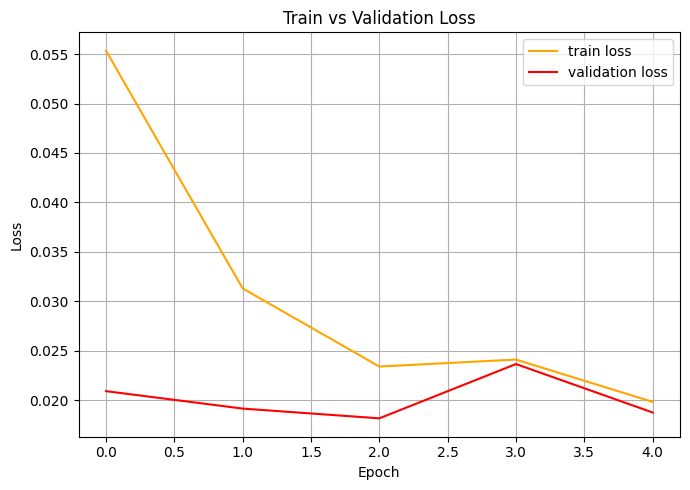

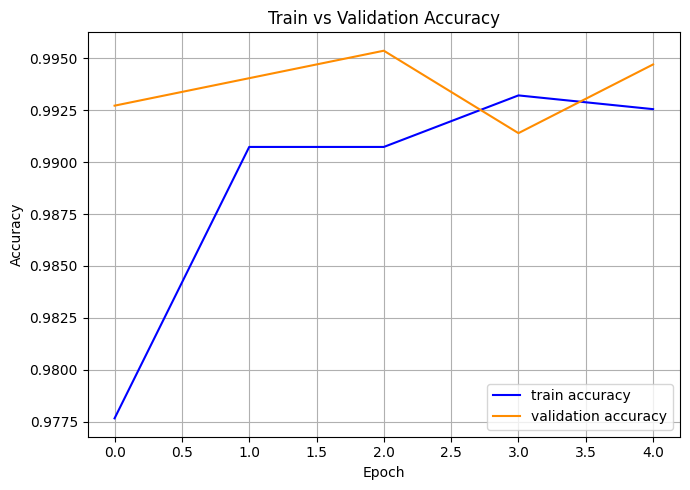

In [42]:
from tqdm import tqdm

# Inisialisasi list untuk simpan train/val loss dan accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validasi
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(test_loader)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print seperti format yang kamu mau
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Plot Train vs Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label='train loss', color='orange')
plt.plot(val_losses, label='validation loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Train vs Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(train_accuracies, label='train accuracy', color='blue')
plt.plot(val_accuracies, label='validation accuracy', color='darkorange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Melatih model klasifikasi menggunakan dataset training dan mengevaluasinya terhadap dataset validasi/test. Hasilnya berupa akurasi dan loss dari tiap epoch yang ditampilkan dan diplot.

# Evaluasi Model

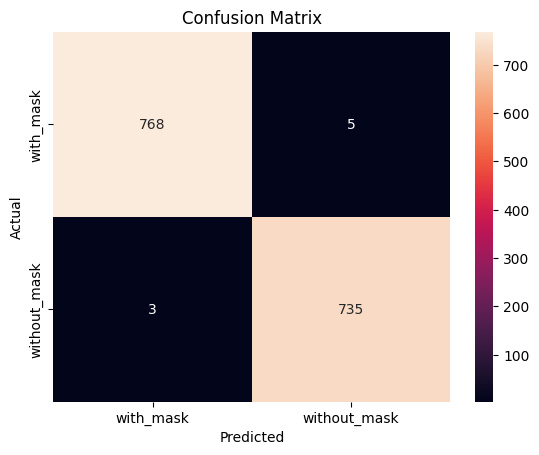

Classification Report:

              precision    recall  f1-score   support

   with_mask       1.00      0.99      0.99       773
without_mask       0.99      1.00      0.99       738

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



In [43]:
model.eval()  # Set model ke mode evaluasi
all_preds = []
all_labels = []

with torch.no_grad():  # Nonaktifkan gradien saat evaluasi untuk efisiensi
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Buat confusion matrix dan tampilkan dengan seaborn
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Tampilkan classification report lengkap
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


Model diuji pada data test, prediksi dan label asli disimpan.
Confusion matrix dan classification report dibuat untuk analisis performa klasifikasi.

# Prediksi Model

In [44]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

def predict_and_show(image_path, model, transform, class_names):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        predicted_class = class_names[pred.item()]
    
    plt.imshow(image)
    plt.axis('off')
    if predicted_class == "with_mask":
        label = "The person in the image is wearing a mask"
    else:
        label = "The person in the image is NOT wearing a mask"
    
    plt.title(label, fontsize=12)
    plt.show()


Melakukan prediksi satu gambar menggunakan model klasifikasi (dalam kasusmu: masker vs tanpa masker), dan menampilkannya secara visual.

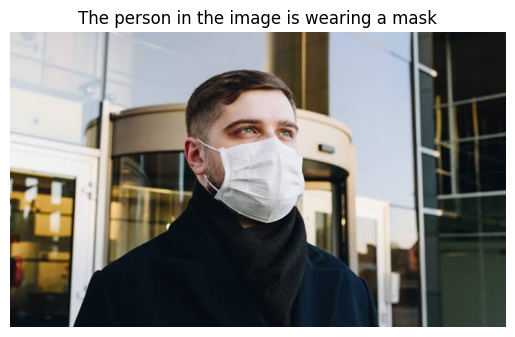

In [46]:
predict_and_show('/kaggle/input/my-images/mask.png', model, transform, full_dataset.classes)

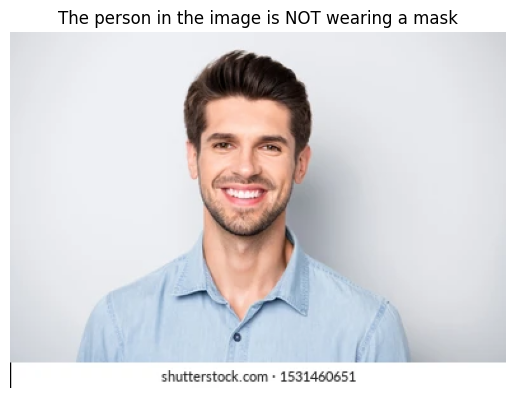

In [47]:
predict_and_show('/kaggle/input/my-images/no_mask.png', model, transform, full_dataset.classes)